# Procesamiento y análisis de información textual

En este documento revisaremos y aplicaremos los siguientes temas:

<ul>
<li>1. Obtención de datos a partir de información textual
<li>2. Detección de temas
<li>3. Clasificación de textos
</ul>

El propósito es descubrir rasgos característicos de las noticias falsas sobre el Covid-19 y ver si es posible clasificar automáticamente noticias falsas con métodos de machine learning. Utilizaremos el dataset <i>corona_fake.csv</i>. Este dataset contiene noticias en inglés sobre el cóvid-19 etiquetadas según sean noticias falsas (fake) o no.

In [1]:
import nltk

# Dejamos la línea comentada porque ya la hemos cargado
nltk.download('all')

import pandas as pd

Comprobamos los datos.

In [2]:
df= pd.read_csv("corona_fake.csv")

df.head()

title  \
0  Due to the recent outbreak for the Coronavirus...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                                text  \
0  You just need to add water, and the drugs and ...   
1  Hydroxychloroquine has been shown to have a 10...   
2  Fact: Hydroxychloroquine has been shown to hav...   
3  The Corona virus is a man made virus created i...   
4  Doesn’t @BillGates finance research at the Wuh...   

                      source label  
0  coronavirusmedicalkit.com  Fake  
1               RudyGiuliani  Fake  
2                CharlieKirk  Fake  
3    JoanneWrightForCongress  Fake  
4    JoanneWrightForCongress  Fake

## 1. Obtención de datos a partir de información textual

Primero, cargamos las librerías necesarias.

Crearemos dos dataframes. El primero (df_fake) contendrá las noticias clasificadas como <i>Fake</i> y el segundo dataframe (df_true) contendrá las noticias clasificadas como <i>TRUE</i>

In [3]:
df_fake = df.loc[df['label'] == 'Fake']

df_fake.head()

title  \
0  Due to the recent outbreak for the Coronavirus...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                                text  \
0  You just need to add water, and the drugs and ...   
1  Hydroxychloroquine has been shown to have a 10...   
2  Fact: Hydroxychloroquine has been shown to hav...   
3  The Corona virus is a man made virus created i...   
4  Doesn’t @BillGates finance research at the Wuh...   

                      source label  
0  coronavirusmedicalkit.com  Fake  
1               RudyGiuliani  Fake  
2                CharlieKirk  Fake  
3    JoanneWrightForCongress  Fake  
4    JoanneWrightForCongress  Fake

In [4]:
df_true = df.loc[df['label'] == 'TRUE']

df_true.head()

title  \
9   Basic protective measures against the new coro...   
14  Exposing yourself to the sun or to temperature...   
16  Being able to hold your breath for 10 seconds ...   
17  Drinking alcohol does not protect you against ...   
18  COVID-19 virus can be transmitted in areas wit...   

                                                 text  \
9   Stay aware of the latest information on the CO...   
14  You can catch COVID-19, no matter how sunny or...   
16  The most common symptoms of COVID-19 are dry c...   
17  Frequent or excessive alcohol consumption can ...   
18  From the evidence so far, the COVID-19 virus c...   

                                               source label  
9   https://www.who.int/emergencies/diseases/novel...  TRUE  
14  https://www.who.int/emergencies/diseases/novel...  TRUE  
16  https://www.who.int/emergencies/diseases/novel...  TRUE  
17  https://www.who.int/emergencies/diseases/novel...  TRUE  
18  https://www.who.int/emergencies/diseases/novel...  TRUE

### 1.1 Encontrar colocaciones

In [5]:
# Importar la lista de stopwords en inglés de la librería NLTK.
stopwords = nltk.corpus.stopwords.words('english')
# Añadir stopwords
stopwords = stopwords + ['unknown', 've', 'hadn', 'll', 'didn', 'isn', 'doesn', 'hasn' ]

Para este apartado es necesario cargar las siguientes librerías:

In [6]:
from nltk import pos_tag, word_tokenize
from nltk.collocations import *
import re

**Primer paso:** Computamos los tokens de los titulares de las noticias falsas. Etiquetamos estos tokens por su PoS. Si una noticia no tiene titular, sustituimos a NaN por 'empty'

In [8]:
# Sustituimos 'Nan' por 'empty'
df_no_na = df.fillna('empty')

# Creamos un dataframe que contiene las noticias falsas
df_fake = df_no_na.loc[df['label'] == 'Fake']

# Creamos un dataframe que contiene las noticias verdaderas
df_true = df_no_na.loc[df['label'] == 'TRUE']

# Eliminamos los titulares vacíos 
titulares_fake_noempty = [fh for fh in df_fake['title'].to_list() if fh != 'empty']
titulares_true_noempty = [th for th in df_true['title'].to_list() if th != 'empty']

# Creamos un texto en minúscula con todos los titulares falsos
titulares_fake = " ".join(titulares_fake_noempty).lower()

# Creamos un texto en minúscula con todos los titulares verdaderos
titulares_true = " ".join(titulares_true_noempty).lower()

Para obtener los bigramas y trigramas de las noticias falsas que no se encuentran en las noticias verdaderas haremos lo siguiente:
- Tokenizar a los titulares de las noticias falsas y verdaderas
- Quedarnos con los tokens únicos de las noticias falsas que no aparecen en las verdaderas
- Etiquetar estos tokens
- Calcular los mejores bigramas y trigramas

In [10]:
# Obtenemos los tokens de las noticias falsas y verdaderas
tokens_fake = word_tokenize(titulares_fake)
tokens_true = word_tokenize(titulares_true)

# Comprobamos
print(tokens_fake[0:10])
print(tokens_true[0:10])

['due', 'to', 'the', 'recent', 'outbreak', 'for', 'the', 'coronavirus', '(', 'covid-19']
['basic', 'protective', 'measures', 'against', 'the', 'new', 'coronavirus', 'exposing', 'yourself', 'to']


Viendo los 10 primeros tokens podemos comprobar la aparición del carácter '('. Además, el enunciado nos dice que puede haber titulares con palabras que tengan caracteres especiales al principio. Por tanto, filtraremos los tokens y eliminaremos todos estos caracteres .

In [11]:
# Primero nos quedamos con los caracteres alfanuméricos para eliminar posibles tokens que sean caracteres especiales
tokens_fake = [c for c in tokens_fake if bool(re.search("[a-z0-9]", c))]
tokens_true = [c for c in tokens_true if bool(re.search("[a-z0-9]", c))]

# Y ahora eliminamos los caracteres especiales del inicio de las palabras
tokens_fake = [re.sub(r"^\W+", "", t) for t in tokens_fake]
tokens_true = [re.sub(r"^\W+", "", t) for t in tokens_true]

# Comprobamos
print(tokens_fake[0:10])
print(tokens_true[0:10])

['due', 'to', 'the', 'recent', 'outbreak', 'for', 'the', 'coronavirus', 'covid-19', 'the']
['basic', 'protective', 'measures', 'against', 'the', 'new', 'coronavirus', 'exposing', 'yourself', 'to']


Observamos que ya no tenemos el carácter '(' en los tokens.

Ahora, a partir de estos tokens nos quedamos con los que sólo están en las noticias falsas:

In [12]:
tokens_only_fake = list(set(tokens_fake) - set(tokens_true))

# Comprobamos
print(tokens_only_fake[0:5])

['recalling', 'biowarfare', 'center', 'guo', 'admit']


Seguimos con el etiquetado de los tokens obtenidos con la función *pos_tag()*:

In [13]:
tags_tokens_only_fake = pos_tag(tokens_only_fake)

# Comprobamos
tags_tokens_only_fake[0:5]

[('recalling', 'VBG'),
 ('biowarfare', 'NN'),
 ('center', 'NN'),
 ('guo', 'NN'),
 ('admit', 'NN')]

**Segundo paso:** Computamos los 1000 mejores bigramas y los 1000 mejores trigramas a partir de los tokens etiquetados de los titulares falsos.

Para obtener los bigramas y trigramas haremos uso de las clases BigramAssocMeasures* y TrigramAssocMeasures*.

**Bigramas**

In [16]:
# Instancia de la clase BigramAssocMeasures
bigram_measures = nltk.collocations.BigramAssocMeasures()

# Obtenemos el buscador de bigramas de los tokens etiquetados
finder = BigramCollocationFinder.from_words(tags_tokens_only_fake)

# Obtenemos los 1000 mejores bigramas con las dos medidas
bigrams_fake_pmi = finder.nbest(bigram_measures.pmi, 1000)
bigrams_fake_lhr = finder.nbest(bigram_measures.likelihood_ratio, 1000)

# Comprobamos
print(bigrams_fake_pmi[0:5])
print("\n")
print(bigrams_fake_lhr[0:5])

[(('1', 'CD'), ('interest', 'NN')), (('15', 'CD'), ('non-essential', 'JJ')), (('150,000', 'CD'), ('bioweapons', 'NNS')), (('19', 'CD'), ('eradicate', 'JJ')), (('20,000', 'CD'), ('cancelled', 'VBD'))]


[(('1', 'CD'), ('interest', 'NN')), (('15', 'CD'), ('non-essential', 'JJ')), (('150,000', 'CD'), ('bioweapons', 'NNS')), (('19', 'CD'), ('eradicate', 'JJ')), (('20,000', 'CD'), ('cancelled', 'VBD'))]


Viendo sólo los 5 primeros bigramas no parece haber diferencias entre las distintas medidas.

Una vez tenemos estos 1000 mejores bigramas, filtraremos aquellos que no tengan ningún stopword al inicio o al final. Para ello hemos reutilizado y modificado las funciones proporcionadas por la UOC.

Tenemos dos funciones:
- La función *good_stw_candidate()* devolverá True o False, dependiendo si el ngrama comienza o termina con *stopwords* o no.
- Y la función *filter_collocation_candidates()* utilizará la función anterior para quedarnos con los ngramas que queremos.

In [17]:
def good_stw_candidate(candidate, stopwords):
    test = True
    if candidate[0] in stopwords or candidate[-1] in stopwords:
        test = False
    return test

def filter_collocation_candidates(candidates, stopwords):
    col_candidates_filtered = [c for c in candidates if good_stw_candidate(c[0], stopwords) == True]
    return col_candidates_filtered

Utilizamos ahora las funciones para filtrar bigramas, tanto los obtenidos con PMI como con Likelihood Ratio.

In [18]:
bigrams_fake_pmi = filter_collocation_candidates(bigrams_fake_pmi, stopwords)
bigrams_fake_lhr = filter_collocation_candidates(bigrams_fake_lhr, stopwords)

# Comprobamos
print(bigrams_fake_pmi[0:5])
print("\n")
print(bigrams_fake_lhr[0:5])

[(('1', 'CD'), ('interest', 'NN')), (('15', 'CD'), ('non-essential', 'JJ')), (('150,000', 'CD'), ('bioweapons', 'NNS')), (('19', 'CD'), ('eradicate', 'JJ')), (('20,000', 'CD'), ('cancelled', 'VBD'))]


[(('1', 'CD'), ('interest', 'NN')), (('15', 'CD'), ('non-essential', 'JJ')), (('150,000', 'CD'), ('bioweapons', 'NNS')), (('19', 'CD'), ('eradicate', 'JJ')), (('20,000', 'CD'), ('cancelled', 'VBD'))]


**Trigramas**

Para conseguir los trigramas, seguiremos los mismos pasos que con los bigramas.

In [19]:
# Instancia de la clase TrigramAssocMeasures
trigram_measures = nltk.collocations.TrigramAssocMeasures()

# Obtenemos el buscador de trigramas de los tokens etiquetados
finder = TrigramCollocationFinder.from_words(tags_tokens_only_fake)

# Obtenemos los 1000 mejores trigramas con las dos medidas
trigrams_fake_pmi = finder.nbest(trigram_measures.pmi, 1000)
trigrams_fake_lhr = finder.nbest(trigram_measures.likelihood_ratio, 1000)

# Comprobamos
print(trigrams_fake_pmi[0:5])
print("\n")
print(trigrams_fake_lhr[0:5])

[(('1', 'CD'), ('interest', 'NN'), ('rollout', 'NN')), (('15', 'CD'), ('non-essential', 'JJ'), ('elderly', 'RB')), (('150,000', 'CD'), ('bioweapons', 'NNS'), ('reactionaries', 'NNS')), (('19', 'CD'), ('eradicate', 'JJ'), ('colonel', 'NNS')), (('20,000', 'CD'), ('cancelled', 'VBD'), ('tag-team', 'NN'))]


[(('1', 'CD'), ('interest', 'NN'), ('rollout', 'NN')), (('15', 'CD'), ('non-essential', 'JJ'), ('elderly', 'RB')), (('150,000', 'CD'), ('bioweapons', 'NNS'), ('reactionaries', 'NNS')), (('19', 'CD'), ('eradicate', 'JJ'), ('colonel', 'NNS')), (('20,000', 'CD'), ('cancelled', 'VBD'), ('tag-team', 'NN'))]


Al igual que lo que hemos visto en los bigramas, con estos 5 primeros trigramas no parece que existen diferencias entre las distintas métricas.

Filtramos aquellos que comienzan o terminan con *stopwords*:

In [20]:
trigrams_fake_pmi = filter_collocation_candidates(trigrams_fake_pmi, stopwords)
trigrams_fake_lhr = filter_collocation_candidates(trigrams_fake_lhr, stopwords)

# Comprobamos
print(trigrams_fake_pmi[0:5])
print("\n")
print(trigrams_fake_lhr[0:5])

[(('1', 'CD'), ('interest', 'NN'), ('rollout', 'NN')), (('15', 'CD'), ('non-essential', 'JJ'), ('elderly', 'RB')), (('150,000', 'CD'), ('bioweapons', 'NNS'), ('reactionaries', 'NNS')), (('19', 'CD'), ('eradicate', 'JJ'), ('colonel', 'NNS')), (('20,000', 'CD'), ('cancelled', 'VBD'), ('tag-team', 'NN'))]


[(('1', 'CD'), ('interest', 'NN'), ('rollout', 'NN')), (('15', 'CD'), ('non-essential', 'JJ'), ('elderly', 'RB')), (('150,000', 'CD'), ('bioweapons', 'NNS'), ('reactionaries', 'NNS')), (('19', 'CD'), ('eradicate', 'JJ'), ('colonel', 'NNS')), (('20,000', 'CD'), ('cancelled', 'VBD'), ('tag-team', 'NN'))]


**Con las métricas utilizadas, ¿es posible encontrar características distintivas en los ngramas de los titulares de noticias falsas?**

Como hemos visto con los 5 primeros bigramas y trigramas no existen diferencias entre la utilización de una métrica u otra. Vemos a continuación si existen diferencias al compararlos todos.

Primero comprobamos el total de bigramas y trigramas que hemos obtenido después del filtrado de stopwords

In [23]:
print(len(bigrams_fake_pmi))
print(len(bigrams_fake_lhr))
print(len(trigrams_fake_pmi))
print(len(trigrams_fake_lhr))

718
718
717
717


Parece que no habrá diferencias con el resultado obtenido, tenemos el mismo número de bigramas y trigramas. Para estar seguros podemos comprobar si existen deferencias en su contenido:

In [24]:
set(bigrams_fake_pmi) - set(bigrams_fake_pmi)

set()

In [25]:
set(trigrams_fake_pmi) - set(trigrams_fake_lhr)

set()

No existen deferencias con el resultado obtenido con las dos métricas.

**¿Qué métrica parece más adecuada para realizar este análisis?**

Teniendo en cuenta lo visto en el capítulo 5 del libro *Foundations of Statistical Natural Language Processing* podemos definir estas métricas de la siguiente manera.

*Pointwise mutual information* (PMI):
- Esta medida se basa en calcular la cantidad de información proporcionada por la influencia de la ocurrencia de una palabra sobre la ocurrencia la otra.
- Tiene problemas con documentos con alta dispersión.

*Likehood ratio*:
- Esta otra métrica parte de dos hipótesis:
    - $H_{0}$: $(w_2 | w_1)$: La aparición de $w_2$ es independiente de si es precedida por $w_1$.
    - $H_{1}$: $(w_2 | w_1)$: La aparición de $w_2$ se ve influenciada por la aparición de $w_1$.
- A partir de estas hipótesis selecciona los mejores n-gramas.
- Es más apropiado para datos dispersos.

En nuestro análisis estamos tratando con un corpus que corresponde a una serie de titulares. Creemos que *Likelihood ratio* sería una mejor medida para evitar problemas con la dispersión de las palabras. De todas formas hemos visto que tanto con una como otra obtenemos los mismos resultados.

**¿Sería más eficiente detectar sólo ngramas que cumplen el patrón sintáctico de un sintagma nominal (e.g: adjetivo + nombre en singular/plural y nombre + nombre)?**

Siguiendo con lo que hemos visto en el capítulo 5 de *Foundations of Statistical Natural Language Processing* podemos decir que sí, sería más eficiente.

Para hacer esta afirmación nos basamos en el ejemplo de *Justenson and Katz*. En su trabajo filtran los tokens obtenidos por su etiquetado siguiendo un patrón específico.

Nosotros hemos tratado los tokens mediante expresiones regulares y la eliminación de *stopwords* para tener un buen resultado, pero aplicando un patrón sintáctico concreto podríamos incluso evitar algunos pasos porque ya no se estarían teniendo en cuenta muchos *stopwords* al no cumplir con el patrón. También cabe destacar que tenemos bigramas y trigramas que comienzan por un token numérico, es posible que esto no nos aporte ninguna información relevante y si definiéramos un patrón concreto lo podríamos corregir fácilmente.

### 1.2 Vectorizar palabras y términos

Exploraremos la vectorización de palabras y términos con el método Word2Vec para obtener los términos relacionados con 'coronavirus' en las noticias falsas y los términos relacionados con 'coronavirus' en las noticias verdaderas.

In [27]:
import gensim

**Primer paso:** Entrenamos un modelo de detección de phrases a una oración. Para el entrenamiento utilizaremos todos los titulares y cuerpos (no vacíos) de las noticias falsas y verdaderas.

Importamos las librerías necesarias:

In [29]:
from gensim.models.phrases import Phrases, Phraser

Creamos el corpus de entrenamiento con todos los titulares y cuerpos.

Ya tenemos las listas con los titulares no vacíos, haremos lo mismo con los cuerpos y después lo juntaremos todo en una lista.

In [30]:
# Seguimos el mismo procedimiento, quedándonos solos con los que no están vacíos
cossos_fake_noempty = [fh for fh in df_fake['text'].to_list() if fh != 'empty']
cossos_true_noempty = [fh for fh in df_true['text'].to_list() if fh != 'empty']

Ahora juntamos las cuatro listas: titulares falsos, titulares verdaderos, cuerpos noticias falsas y cuerpos noticias verdaderas.

In [31]:
text = titulares_fake_noempty + titulares_true_noempty + cossos_fake_noempty + cossos_true_noempty

Seguidamente, preparamos estas oraciones tokenizándolas para poder entrenar el modelo.

In [32]:
tokens_text = [word_tokenize(d.lower()) for d in text]

Como no se especifica ningún requisito en lo que se refiere a los parámetros en la creación del modelo utilizaremos todos los valores por defecto excepto el delimitador, donde indicaremos un espacio en blanco para separar los bigramas.

Creamos el modelo:

In [33]:
phrases_model = Phrases(tokens_text,delimiter=' ')

# Comprobamos
phrases_model

En este punto ya tenemos creado el modelo, pero ahora utilizaremos la clase Phraser sobre él. Este paso sirve para reducir el uso de memoria del modelo, pero debe tenerse en cuenta que ya no podremos actualizarlo.

In [34]:
phrases_model = Phraser(phrases_model)

# Comprobamos
phrases_model

Como podemos comprobar, después de aplicar *Phraser()* pasamos de tener un objeto *Phrases* a un objeto *FrozenPhrases*.

**Segundo paso:** Transforma cada frase de las noticias fake en una lista de phrases lematizadas

Importamos las librerías que nos serán necesarias:

In [37]:
from nltk.tokenize import sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

Para llevar a cabo este segundo paso podemos partir de las variables *titulares_fake_noempty* y *cuerpos_fake_noempty* obtenidos anteriormente.

Crearemos una función para poder reutilizarla.

In [38]:
def check_phrases(phrases, stopwords):
    # Mediante expresiones regulares nos quedamos solos con valores alfanuméricos    
    phrases = [c for c in phrases if bool(re.search("[a-z0-9]", c))]    
    
    # Eliminamos también caracteres especiales de posibles inicios de palabras tal y como habíamos hecho en el apartado anterior
    phrases = [re.sub(r"^\W+", "", t) for t in phrases]  
    
    # Utilizamos la función que ya habíamos definido para eliminar los stopwords
    phrases = [c for c in phrases if good_stw_candidate(c.split(), stopwords) == True]
    
    return phrases

def get_phrases_lemmatized(sentence, model, stopwords):
    # Obtenemos los tokens
    tokens = word_tokenize(sentence.lower())
    
    # Obtenemos las phrases
    phrases = model[tokens]
    
    # Filtramos que las phrases
    phrases = check_phrases(phrases, stopwords)
    
    # Lematizamos las phrases
    lem = WordNetLemmatizer()
    phrases = [lem.lemmatize(s) for s in phrases]

    return phrases

Ahora prepararemos el texto que debemos pasar a la función. Para ello dividiremos el texto del cuerpo de las noticias en frases y después las juntaremos con los titulares que ya tenemos en *titulares_fake_noempty*. De esta forma tendremos todas las frases correspondiente a las noticias *fake*.

In [39]:
sentences_cossos_fake = [sent_tokenize(s) for s in cossos_fake_noempty]

# Comprobamos 
sentences_cossos_fake[0:3]

[['You just need to add water, and the drugs and vaccines are ready to be administered.',
  'There are two parts to the kit: one holds pellets containing the chemical machinery that synthesises the end product, and the other holds pellets containing instructions that telll the drug which compound to create.',
  'Mix two parts together in a chosen combination, add water, and the treatment is ready.'],
 ['Hydroxychloroquine has been shown to have a 100% effective rate treating COVID-19.',
  'Yet Democrat Gretchen Whitmer is threatening doctors who prescribe it.',
  'If Trump is for something, Democrats are against it.',
  'They are okay with people dying if it means opposing Trump.'],
 ['Fact: Hydroxychloroquine has been shown to have a 100% effective rate treating COVID-19.',
  'Yet Democrat Gretchen Whitmer is threatening doctors who prescribe it.',
  'If Trump is for something, Democrats are against it.',
  'They are okay with people dying if it means opposing Trump.',
  'SICK!']]

Como puede observarse, tenemos una lista multidimensional. Para poder concatenar la lista de titulares con esta lista sin problemas para después aplicar el modelo *Word2Vec* deberemos convertir la lista de frases del cuerpo de las noticias en una lista unidimensional.

In [40]:
sentences_cossos_fake = [element for sub in sentences_cossos_fake for element in sub]

# Comprobamos
sentences_cossos_fake[0:3]

['You just need to add water, and the drugs and vaccines are ready to be administered.',
 'There are two parts to the kit: one holds pellets containing the chemical machinery that synthesises the end product, and the other holds pellets containing instructions that telll the drug which compound to create.',
 'Mix two parts together in a chosen combination, add water, and the treatment is ready.']

Ahora podemos juntar el cuerpo de las noticias falsas con los titulares.

In [41]:
sentences_fake = titulares_fake_noempty + sentences_cossos_fake

Utilizamos las funciones creadas para obtener las phrases lematizadas de cada frase de las noticias falsas:

In [42]:
phrases_fake_lem = [get_phrases_lemmatized(s, phrases_model, stopwords) for s in sentences_fake]

# Comprobamos
phrases_fake_lem[0:3]

[['recent',
  'outbreak',
  'coronavirus',
  'covid-19',
  'world health',
  'organization',
  'giving',
  'away',
  'vaccine',
  'kit',
  'pay',
  '4.95',
  'shipping'],
 ['china',
  'seek',
  'court',
  'approval',
  'kill',
  '20,000',
  'coronavirus',
  'patient',
  'avoid',
  'spread',
  'virus'],
 ['coronavirus',
  'originate',
  'chinese government',
  'laboratory',
  'scientists believe',
  'killer',
  'disease',
  'begun',
  'research',
  'facility',
  '300',
  'yard',
  'wuhan',
  'wet',
  'fish',
  'market']]

**Tercer paso:** Crear un modelo word2vec de los titulares y los cuerpos de noticias falsas

Importamos la librería *Word2Vec* de Gensim:

In [45]:
from gensim.models import Word2Vec

Como no se indica ningún requisito, para crear el modelo utilizaremos los valores de los hiperparámetros por defecto.

Le pasamos la lista de *phrases* lematizadas que hemos obtenido en el apartado anterior.

In [46]:
w2v_model_fake = Word2Vec(phrases_fake_lem)

**Cuarto paso:** Seleccionar el vocabulario del modelo word2vec sobre el que se verán los términos similares

Podemos acceder al vocabulario del modelo a través del atributo *index_to_key*:

In [49]:
list(w2v_model_fake.wv.index_to_key)[0:10]

['coronavirus',
 'virus',
 'vaccine',
 'china',
 'people',
 'also',
 'one',
 'covid-19',
 'wuhan',
 'world']

Vemos también el total de términos que lo forman:

In [50]:
len(w2v_model_fake.wv.index_to_key)

4311

Pero como podemos fijarnos, con estos 10 primeros términos tenemos algunos como *also* que no nos aportarán mucha información. Por ello, antes de obtener los términos más parecidos filtraremos el vocabulario.

Para ello seguiremos lo que hemos visto a lo largo del máster. Hemos reutilizado y modificado las funciones good_candidate* y phrases_is_term* para adaptarlas a nuestras necesidades.

La función *good_candidate* devolverá true o false dependiendo si la phrase que si le pase cumple con nuestros requisitos. Es decir, si no comienza ni termina por el tipo sintáctico que le hemos especificado en *no_pos_in* y si no es una stopword*.

Por otra parte, la función phrase_is_term será la encargada de realizar el proceso previo necesario en la phrases (tokenizar y etiquetar) para poder utilizar la función anterior y devolver True o False dependiendo si la phrase es elegible o no.

In [51]:
# Lista de etiquetas que no pueden tener el token inicial y final
# Elegimos los mismos tipos que los definidos en el notebook
no_pos_in = ['DT', 'IN', 'PRP', 'CC', 'CD','MD', 'VBG', 'VBD', 'RP', 'RB']

def good_candidate(t,postag):
    v = False
    tl = t.split()
    
    # En nuestro caso no será necesario diferenciar para multipalabra o monopalabra.
    # Si es monopalabra las comprobaciones con tl[0] y tl[1] serán sobre la misma palabra, el split() no nos afectará.
    
    # Comprobamos que ni el token inicial y final son stopwords Ni pertenecen a algún tipo definido en no_pos_in    
    if re.match("^[a-z]+.*", tl[0]) and re.match("^[a-z]+.*", tl[-1]) and \
        tl[0] not in stopwords and tl[-1] not in stopwords:
        
        # ni pertenecen a algún tipo definido en no_pos_in
        if postag[0][1] not in no_pos_in and postag[-1][1] not in no_pos_in:
            v = True
            
    return v

def phrase_is_term(phrase):
    test = False
    
    # Tokenitzem y etiquetamos la phrase
    pos = nltk.pos_tag(word_tokenize(phrase))
    
    # Comprobamos si cumple los requisitos
    if good_candidate(phrase,pos):
        test = True
        
    return test

Guardamos en una variable el vocabulario completo obtenido por el modelo:

In [52]:
vocab_fake = w2v_model_fake.wv.index_to_key

Aplicamos las funciones que hemos definido:

In [53]:
terms_vocabulary_fake = [pv for pv in vocab_fake if phrase_is_term(pv) == True]

Comprobamos el total de términos que han pasado los filtros:

In [54]:
len(terms_vocabulary_fake)

3499

Como podemos observar, tenemos alrededor de 800 términos menos respecto al vocabulario completo.

**Quinto paso:** Presentar los términos fake más cercanos semánticamente a 'coronavirus'

En este paso ya tenemos los términos sobre los que queremos obtener el parecido respecto a la palabra 'coronavirus'. Para ello tomaremos otra función del notebook. Esta función calculará la distancia de nuestra palabra respecto a cada término del vocabulario y devolverá una lista de tuplas ordenada por el valor de similitud alcanzado.

In [57]:
def get_similarity_distance(word,vocabulary,model):
    
    # Variable donde se almacenarán todas las tuplas [término, valor similitud]
    w2v_tuples = []

    # Para cada término del vocabulario se calcula la distancia.
    # Si es mayor a 0, se añade a la variable anterior
    for i in range(0, len(vocabulary)):
        if vocabulary[i] != word and model.wv.similarity(word, vocabulary[i]) > 0:
            w2v_tuples.append((vocabulary[i], model.wv.similarity(word, vocabulary[i])))
    
    # Devolvemos la lista ordenada por el valor
    return sorted(w2v_tuples, key=lambda tup: tup[1], reverse=True)

Calculamos la similitud del vocabulario respecto a coronavirus y observamos los 10 más cercanos.

In [58]:
similarty_fake = get_similarity_distance('coronavirus',terms_vocabulary_fake,w2v_model_fake)
similarty_fake[0:10]

[('covid-19', 0.99975306),
 ('viral', 0.99973166),
 ('similar', 0.99966997),
 ('new', 0.99966556),
 ('disease', 0.99966276),
 ('virus', 0.9996596),
 ('world', 0.99965805),
 ('coronaviruses', 0.9996577),
 ('epidemic', 0.99965656),
 ('chinese', 0.9996531)]

Vemos también la diferencia si no hubiéramos filtrado el vocabulario:

In [59]:
get_similarity_distance('coronavirus',w2v_model_fake.wv.index_to_key,w2v_model_fake)[0:10]

[('covid-19', 0.99975306),
 ('viral', 0.99973166),
 ('first', 0.99971443),
 ('including', 0.9996948),
 ('similar', 0.99966997),
 ('already', 0.99966973),
 ('new', 0.99966556),
 ('disease', 0.99966276),
 ('virus', 0.9996596),
 ('world', 0.99965805)]

Podemos ver que en esta lista hay algunos elementos que presumiblemente no nos están aportando ninguna información como 'first' o 'already'.

**Sexto paso:** Realiza los pasos anteriores pero con las frases de las noticias verdaderas

Para realizar este paso nos serviremos de las funciones que hemos definido en los apartados anteriores.

Primero pasamos los cuerpos de las noticias verdaderas a oraciones:

In [62]:
sentences_cossos_true = [sent_tokenize(s) for s in cossos_true_noempty]

# Comprobamos 
sentences_cossos_true[0:3]

[['Stay aware of the latest information on the COVID-19 outbreak, available on the WHO website and through your national and local public health authority.',
  'Most people who become infected experience mild illness and recover, but it can be more severe for others.',
  'Take care of your health and protect others by doing the following: Wash your hands frequently.',
  'Regularly and thoroughly clean your hands with an alcohol-based hand rub or wash them with soap and water.Why?',
  'Washing your hands with soap and water or using alcohol-based hand rub kills viruses that may be on your hands.',
  'Maintain social distancing.',
  'Maintain at least 1 metre (3 feet) distance between yourself and anyone who is coughing or sneezing.',
  'Why?',
  'When someone coughs or sneezes they spray small liquid droplets from their nose or mouth which may contain virus.',
  'If you are too close, you can breathe in the droplets, including the COVID-19 virus if the person coughing has the disease.',

Ahora convertimos esta lista multidimensional en unidimensional:

In [63]:
sentences_cossos_true = [element for sub in sentences_cossos_true for element in sub]

# Comprobamos
sentences_cossos_true[0:3]

['Stay aware of the latest information on the COVID-19 outbreak, available on the WHO website and through your national and local public health authority.',
 'Most people who become infected experience mild illness and recover, but it can be more severe for others.',
 'Take care of your health and protect others by doing the following: Wash your hands frequently.']

Lo juntamos con la lista de titulares de las noticias verdaderas.

In [64]:
sentences_true = titulares_true_noempty + sentences_cossos_true

Obtenemos las *phrases* lemmatizadas de cada oración:

In [65]:
phrases_true_lem = [get_phrases_lemmatized(s, phrases_model, stopwords) for s in sentences_true]

# Comprobamos
phrases_true_lem[0:3]

[['basic', 'protective measures', 'new coronavirus'],
 ['exposing',
  'sun',
  'temperature',
  '25c',
  'degree',
  'prevent',
  'coronavirus',
  'disease',
  'covid-19'],
 ['hold',
  'breath',
  '10 seconds',
  'without',
  'feeling',
  'discomfort',
  'mean',
  'free',
  'coronavirus',
  'disease',
  'covid-19',
  'lung disease']]

Creamos el modelo Word2Vec con estas phrases*:

In [66]:
w2v_model_true = Word2Vec(phrases_true_lem)

Seguidamente pasamos a filtrar el vocabulario.

In [67]:
vocab_true = w2v_model_true.wv.index_to_key

Comprobamos el total de elementos del vocabulario original:

In [68]:
len(w2v_model_true.wv.index_to_key)

4681

Filtramos:

In [69]:
terms_vocabulary_true= [pv for pv in vocab_true if phrase_is_term(pv) == True]

Comprobamos los términos que han pasado el filtro:

In [70]:
len(terms_vocabulary_true)

3744

Ya tenemos el vocabulario seleccionado, así que ahora obtenemos los términos más similares en las noticias verdaderas:

In [71]:
similarty_true = get_similarity_distance('coronavirus',terms_vocabulary_true,w2v_model_true)
similarty_true[0:10]

[('new', 0.9993708),
 ('coronaviruses', 0.999271),
 ('similar', 0.99925286),
 ('disease', 0.99925184),
 ('new coronavirus', 0.9991074),
 ('sars-cov-2', 0.99903923),
 ('caused', 0.9989004),
 ('influenza', 0.99889404),
 ('illness', 0.99887466),
 ('cause', 0.9987763)]

**Analizamos ahora las diferencias que existen en los términos relacionados con 'coronavirus' en las noticias falsas y en las noticias verdaderas.**

Viendo el top 10 de elementos más similares podemos observar algunas diferencias respecto a los términos más similares.

Si recuperamos las listas y vemos varios términos más podemos ver lo siguiente:

In [74]:
similarty_fake[0:25]

[('covid-19', 0.99975306),
 ('viral', 0.99973166),
 ('similar', 0.99966997),
 ('new', 0.99966556),
 ('disease', 0.99966276),
 ('virus', 0.9996596),
 ('world', 0.99965805),
 ('coronaviruses', 0.9996577),
 ('epidemic', 0.99965656),
 ('chinese', 0.9996531),
 ('test', 0.99965024),
 ('national', 0.9996493),
 ('outbreak', 0.99964786),
 ('key', 0.99964666),
 ('many', 0.9996326),
 ('made', 0.99963236),
 ('study', 0.999629),
 ('rate', 0.9996272),
 ('market', 0.99962664),
 ('given', 0.99962467),
 ('show', 0.9996245),
 ('spread', 0.99962354),
 ('fact', 0.9996218),
 ('say', 0.9996213),
 ('country', 0.99962)]

In [75]:
similarty_true[0:25]

[('new', 0.9993708),
 ('coronaviruses', 0.999271),
 ('similar', 0.99925286),
 ('disease', 0.99925184),
 ('new coronavirus', 0.9991074),
 ('sars-cov-2', 0.99903923),
 ('caused', 0.9989004),
 ('influenza', 0.99889404),
 ('illness', 0.99887466),
 ('cause', 0.9987763),
 ('novel coronavirus', 0.9987376),
 ('epidemic', 0.9987005),
 ('outbreak', 0.99867374),
 ('bat', 0.99865687),
 ('found', 0.9986156),
 ('known', 0.99861157),
 ('strain', 0.9986056),
 ('likely', 0.9985966),
 ('flu', 0.9985815),
 ('case', 0.99855506),
 ('different', 0.9985367),
 ('respiratory', 0.9985094),
 ('transmission', 0.9985024),
 ('ebola', 0.9984876),
 ('related', 0.9984764)]

En los términos más parecidos de las noticias falsas aparecen algunos como 'chinese', 'made' o 'market', que no aparecen en los términos más parecidos de las noticias verdaderas. Esto podría hacer referencia a todas aquellas noticias de carácter conspiranoico que surgieron en su día.

Respecto a los términos de las noticias verdaderas podemos encontrar que muchas podrían estar relacionadas con ámbitos más académicos o médicos como 'novel coronavirus', 'fluo' o 'new coronavirus'. Es posible que estas noticias pongan el énfasis en los síntomas, las causas o los posibles estudios que fueron surgiendo.

Por otra parte, nos llama también la atención el término más similar que hace referencia al virus. En las noticias falsas es 'covid-19', pero en las noticias verdaderas es 'sars-cov-2'.

Todo indica que las diferencias entre noticias verdaderas y falsas serán significativas. Como hemos visto con nuestra propia experiencia, durante este tiempo de pandemia han abundado muchas noticias que sólo buscaban el máximo de visualizaciones con la utilización de titulares muy llamativos o directamente con informaciones falsas.

Podemos comprobar la posición de algunos de los términos que más clickbait podrían producir como 'chinese', 'china' o 'made' respecto a las dos listas de similitudes.

In [76]:
print([y[0] for y in similarty_fake].index('chinese'))
print([y[0] for y in similarty_true].index('chinese'))

9
433


In [77]:
print([y[0] for y in similarty_fake].index('china'))
print([y[0] for y in similarty_true].index('china'))

32
208


In [78]:
print([y[0] for y in similarty_fake].index('made'))
print([y[0] for y in similarty_true].index('made'))

15
282


Observamos fácilmente cómo estos términos que están muy relacionados con la palabra 'coronavirus' en las noticias falsas están bastante más lejos si los comprobamos en las noticias verdaderas.

## 2. Detección de temas

En estos apartados exploraremos los temas tratados en las noticias falsas.

### 2.1 Exploración de los temas con WordNet

En este apartado accederemos a Wordnet a través de la librería nltk. Comprobaremos si las noticias falsas contienen términos alejados semánticamente del sentido del término 'disease' en Wordnet.

In [80]:
from nltk.corpus import wordnet as wn

**Primer paso:** Calcular la distancia Wu and Palmer entre el sentido 'disease.n.01' y el primer sentido de los sustantivos más relacionados con 'coronavirus' en el modelo word2vec de las noticias falsas.

En primer lugar, capturamos en una variable los 10 sustantivos más relacionados con coronavirus que hemos obtenido con Word2Vec. Utilizaremos la función *pos_tag* y nos quedaremos con aquellos 10 primeros términos que se etiquetan con 'NN'.

In [82]:
n = 0
i = 0
top_ten_fake = []

# Recorremos la lista de términos y nos quedamos solos con los 10 primeros que cumplen la condición
while n < 10 or i > len(similarty_fake):
    term = similarty_fake[i][0]
    if(pos_tag([term])[0][1] == 'NN'):
        top_ten_fake.append(term)
        n += 1
    i += 1

# Comprobamos
top_ten_fake

['covid-19',
 'disease',
 'virus',
 'world',
 'test',
 'outbreak',
 'key',
 'study',
 'rate',
 'market']

Siguiendo con lo que hemos visto en el máster, obtendremos el primer *synset* de cada término (si lo tienen) y calcularemos la similitud.

In [83]:
disease = wn.synset('disease.n.01')
synsets_fake = []
for term in top_ten_fake:
    synsets = wn.synsets(term)
    if len(synsets) > 0:
        print('La distància entre disease i',term,'és:', disease.wup_similarity(synsets[0]))
    else:
        print("No s'han trobat synsets per al terme", term)


No s'han trobat synsets per al terme covid-19
La distància entre disease i disease és: 1.0
La distància entre disease i virus és: 0.125
La distància entre disease i world és: 0.125
La distància entre disease i test és: 0.19047619047619047
La distància entre disease i outbreak és: 0.25
La distància entre disease i key és: 0.1111111111111111
La distància entre disease i study és: 0.2
La distància entre disease i rate és: 0.26666666666666666
La distància entre disease i market és: 0.23529411764705882


**Pasamos a analizar los resultados que más nos han llamado la atención.**

Lo primero que nos llama la atención es que no hemos encontrado un *synset* para el término 'covid-19'. Esto puede deberse a que WordNet no esté suficientemente actualizado para este término, ya que es relativamente nuevo.

Otra cosa que nos llama la atención es que no hay ninguna distancia muy cercana a coronavirus. La similitud de Wu and Palmer nos devuelve un valor entre 0 y 1, cuanto más cercano a 1 nos indicará que el significado de los términos está más relacionado.

Un término que podría parecernos relacionado con 'disease' antes de realizar el cálculo era 'virus', pero como podemos observar nos ha devuelto un valor de 0.125.

Vemos qué significados se están relacionando entre los synsets de 'disease' y virus':

In [86]:
print("Disease:", disease.definition())
print("Virus:", wn.synsets('virus')[0].definition())

Disease: an impairment of health or a condition of abnormal functioning
Virus: (virology) ultramicroscopic infectious agent that replicates itself only within cells of living hosts; many are pathogenic; a piece of nucleic acid (DNA or RNA) wrapped in a thin coat of protein


Con las definiciones podemos ver porqué no hemos obtenido una gran similitud. El significado de 'disease' que está cogiendo hace referencia a un deterioro de la salud y el significado de virus que estamos comparando hace referencia al agente en sí sin relacionarlo con la salud.

Un último término que nos llama la atención es 'china', comprobamos su distancia:

In [87]:
disease.wup_similarity(wn.synsets('china')[0])

0.1

Presenta un pequeño valor. Podemos ver qué definición está cogiendo, aunque es fácil prever que hará referencia a China como país:

In [88]:
print("China:", wn.synsets('china')[0].definition())

China: a communist nation that covers a vast territory in eastern Asia; the most populous country in the world


Efectivamente, hace referencia al país, sin relación alguna con problemas de salud.

Vistos estos resultados creamos que Wordnet no es un buen recurso para analizar los temas tratados en las noticias falsas. Por una parte tenemos términos que no están catalogados como 'covid-19' y, por otra parte, tenemos términos cuya relación va más allá de su significado. Es una relación sin sentido sin el contexto. Por ejemplo, la relación entre 'china' y 'coronavirus' no se podrá tener en cuenta comparando sólo la similitud de su significado e ignorando el contexto, ya que su relación tiene que ver al ser China el país donde se notificaron los primeros casos de coronavirus.

### 2.2 LDA

En este apartado utilizaremos LDA para detectar los temas del conjunto de noticias que tenemos.

Para llevar a cabo la detección de temas mediante LDA utilizaremos las phrases* de los titulares y cuerpos de las noticias falsas que ya tenemos tratadas en la variable *phrases_fake_lem*. Ahora bien, de estas *phrases* sólo nos interesan los términos nominales, es decir, los nombres.

Por eso cargaremos las siguientes funciones proporcionadas por la UOC:

In [91]:
def isnp(t):
    v = False
    # Si el término es una multipalabra, asumimos que es un término nominal
    if ' ' in t:
        v = True
    # Si el término monopalabra no tiene synset en Wordnet, asumimos que es un término nominal que todavía no se ha incluido en Wordnet
    elif wn.synsets(t) == []: 
        v = True
    else:
        try:
            # Si hay un synset del término que es nominal, entonces el término es nominal
            wn.synset(t + '.n.01')
            v = True
        except:
            pass
    return v    

def get_nominals(sentence, terms_vocabulary):
    nps = [np for np in sentence if np in terms_vocabulary 
           and isnp(np) == True ] 
    return nps

Estas funciones se encargarán de filtrar las *phrases* para quedarnos solos en aquellos términos nominales. Podrán ser tanto monopalabra como multipalabra.

Hemos adaptado la función *get_nominals()* para pasarle el vocabulario con el que queremos que filtre los términos de *phrases_fake_lem*. En nuestro caso, le pasaremos el vocabulario del modelo Word2Vec que habíamos tratado anteriormente.

In [92]:
nps_in_sentences = [get_nominals(p, terms_vocabulary_fake) for p in phrases_fake_lem if len(get_nominals(p, terms_vocabulary_fake)) > 0]

Podemos observar un ejemplo de la diferencia entre las *phrases* antes y después de aplicar las funciones:

In [93]:
phrases_fake_lem[0]

['recent',
 'outbreak',
 'coronavirus',
 'covid-19',
 'world health',
 'organization',
 'giving',
 'away',
 'vaccine',
 'kit',
 'pay',
 '4.95',
 'shipping']

In [94]:
nps_in_sentences[0]

['recent',
 'outbreak',
 'coronavirus',
 'covid-19',
 'world health',
 'organization',
 'vaccine',
 'kit',
 'pay']

Como vemos, en el resultado obtenido no tenemos términos como 'giving', 'away' o '4.95', sólo tenemos términos nominales.

Ahora importamos la librería necesaria para aplicar LDA:

In [95]:
import gensim.corpora as corpora

En el *notebook* se ha implementado una función para calcular todos los parámetros de LDA y después aplicar el modelo. Haremos algo similar pero adaptando un poco la función.

In [96]:
def lda(terms, num_topics, passes):
    
    dictionary = corpora.Dictionary(terms)
    corpus = [dictionary.doc2bow(t) for t in terms]
    
    # Creación del modelo
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, random_state=1, id2word = dictionary, passes=passes) 
    
    return ldamodel

LDA es un método no supervisado que necesita tener definido el número *k* de temas que van a existir. Para ayudarnos a elegir un número *k* óptimo utilizaremos el concepto de coherencia. La coherencia de un tema indica el grado de similitud de todas las palabras que pertenecen al tema. El objetivo será maximizar este valor, puesto que un buen modelo generará temáticas con una alta coherencia.

Para calcular la coherencia de los modelos obtenidos utilizaremos la librería CoherenceModel.

In [97]:
from gensim.models.coherencemodel import CoherenceModel

Ahora utilizaremos el siguiente bucle para calcular varios modelos y obtener su coherencia. Este código es una modificación del código expuesto en el artículo de [Khuyen Tran](https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should- know).

Utilizaremos passes=25, puesto que si no el coste computacional es demasiado elevado para nuestra máquina.

In [98]:
model_list = []
coherence_values = []
dictionary = corpora.Dictionary(nps_in_sentences)

for num_topics in range(2, 30, 1):
    model = lda(nps_in_sentences, num_topics, 25)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=nps_in_sentences, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

Una vez calculadas las coherencias de todos los modelos, podemos compararlas en un gráfico:

In [99]:
import matplotlib.pyplot as plt

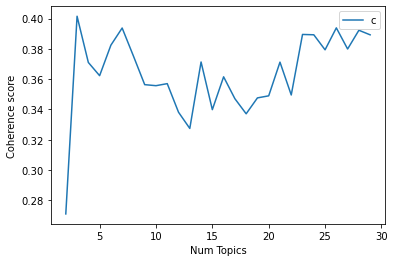

In [100]:
x = range(2, 30, 1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Podemos ver que tenemos máximos valores de alrededor de 3 y 7 y también entre 25 y 30 temas.

Otra herramienta que nos puede ayudar a elegir la temática es la visualización mediante *pyLDAvis*. Esta visualización consta de dos partes. Por un lado, tenemos unas burbujas que representan los temas, cuanto más separadas estén más se diferenciarán las temáticas entre sí. Por otro lado, tenemos un gráfico de barras con las palabras más representativas de la temática seleccionada.

A continuación cargaremos las librerías necesarias para realizar esta visualización y representaremos los modelos creados con 3, 7 y 26 temas. Como los tenemos todos en la variable *model_lists* será fácil acceder a ellos.

In [101]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

Crearemos la variable *corpus* y reutilizaremos la variable *dictionary* creada anteriormente.

In [102]:
corpus = [dictionary.doc2bow(text) for text in nps_in_sentences]

In [103]:
vis_3 = gensimvis.prepare(model_list[1], corpus, dictionary)
vis_3

C:\Users\Casa\anaconda3\envs\AST-PRAs\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.065862 -0.229832       1        1  40.821649
1     -0.248710  0.062302       2        1  31.553051
0      0.182848  0.167530       3        1  27.625301, topic_info=         Term         Freq        Total Category  logprob  loglift
7     vaccine   718.000000   718.000000  Default  30.0000  30.0000
16      virus  1037.000000  1037.000000  Default  29.0000  29.0000
24      wuhan   417.000000   417.000000  Default  28.0000  28.0000
10      china   687.000000   687.000000  Default  27.0000  27.0000
23   research   276.000000   276.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
433     cause    76.669609   104.567585   Topic3  -5.4223   0.9761
1    covid-19   145.712717   427.868224   Topic3  -4.7802   0.2093
167     study    95.198614   175.194651   Topic3  -5.2059   0.6765
609     child    80.895332   128.400280   Topic3  -5.3687   0.8244
157      time    85.227841   255.433612   Topic3  -5.3165   0.1888

[169 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
108       1  0.863326         american
108       2  0.132819         american
649       2  0.989694           animal
1790      3  0.992516      antioxidant
2416      3  0.981897             ards
...     ...       ...              ...
56        1  0.796257            world
56        2  0.201754            world
24        1  0.002393            wuhan
24        2  0.997893            wuhan
692       2  0.989315  wuhan institute

[192 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [104]:
vis_7 = gensimvis.prepare(model_list[5], corpus, dictionary, mds='mnds', R=30)
vis_7

C:\Users\Casa\anaconda3\envs\AST-PRAs\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.194169  0.162299       1        1  17.705692
1      0.184781  0.095885       2        1  14.671950
5      0.231869  0.061021       3        1  14.428777
6     -0.192286  0.006865       4        1  13.808627
4     -0.027491  0.044170       5        1  13.657863
3      0.004454 -0.040378       6        1  13.513492
0     -0.007157 -0.329863       7        1  12.213600, topic_info=            Term         Freq        Total Category  logprob  loglift
7        vaccine   728.000000   728.000000  Default  30.0000  30.0000
24         wuhan   399.000000   399.000000  Default  29.0000  29.0000
16         virus  1020.000000  1020.000000  Default  28.0000  28.0000
94     vitamin c   236.000000   236.000000  Default  27.0000  27.0000
115         case   274.000000   274.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
328    pneumonia    41.735715    77.028693   Topic7  -5.2143   1.4898
0    coronavirus    84.558199  1249.553238   Topic7  -4.5082  -0.5905
362           go    41.689014   107.625839   Topic7  -5.2154   1.1542
505        death    46.402652   218.635333   Topic7  -5.1083   0.5526
746       result    38.803290    97.050643   Topic7  -5.2871   1.1859

[441 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
133       5  0.961070  acute respiratory
373       3  0.289166             agency
373       4  0.702260             agency
108       2  0.259654           american
108       3  0.057701           american
...     ...       ...                ...
150       4  0.434859               year
150       5  0.058765               year
150       6  0.287947               year
150       7  0.111653               year
70        2  0.961614                yes

[694 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 6, 7, 5, 4, 1])

In [105]:
vis_26 = gensimvis.prepare(model_list[24], corpus, dictionary, mds='mnds', R=30)
vis_26

C:\Users\Casa\anaconda3\envs\AST-PRAs\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1     -0.258601 -0.071091       1        1  5.719121
5     -0.209655 -0.126271       2        1  5.423079
25    -0.134748  0.083491       3        1  4.736108
16    -0.183522  0.051067       4        1  4.623487
12    -0.046496  0.186522       5        1  4.607970
19     0.114671 -0.111967       6        1  4.484734
18     0.075415 -0.011357       7        1  4.461830
22    -0.064001 -0.141847       8        1  4.368389
8     -0.078411  0.166996       9        1  4.281004
15     0.060397  0.023573      10        1  3.897529
13     0.118544 -0.068616      11        1  3.865056
0     -0.041140  0.070303      12        1  3.761374
6      0.082040  0.157142      13        1  3.738724
3     -0.093193  0.081504      14        1  3.725269
7      0.038227 -0.156281      15        1  3.501758
24     0.114334 -0.082496      16        1  3.501652
11     0.073472  0.056594      17        1  3.461875
10    -0.026980 -0.106994      18        1  3.414275
14    -0.060945 -0.142831      19        1  3.239255
2      0.029693  0.061718      20        1  3.237046
9     -0.090923  0.101457      21        1  3.192876
23     0.133254  0.072398      22        1  3.081508
20     0.152567  0.050537      23        1  3.045963
17     0.151674  0.013439      24        1  2.980654
4      0.119657 -0.021258      25        1  2.847050
21     0.024669 -0.135731      26        1  2.802413, topic_info=         Term         Freq        Total Category  logprob  loglift
7     vaccine   812.000000   812.000000  Default  30.0000  30.0000
27     people   632.000000   632.000000  Default  29.0000  29.0000
16      virus  1111.000000  1111.000000  Default  28.0000  28.0000
10      china   720.000000   720.000000  Default  27.0000  27.0000
24      wuhan   434.000000   434.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
965       low    22.709720    43.943282  Topic26  -4.3508   2.9146
278    system    28.935282   195.146842  Topic26  -4.1085   1.6660
16      virus    47.170257  1111.461144  Topic26  -3.6198   0.4150
285   medical    26.193573   171.994587  Topic26  -4.2081   1.6927
74   sequence    16.321902   101.712017  Topic26  -4.6811   1.7451

[1313 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
682      11  0.197570   ability
682      16  0.065857   ability
682      18  0.691494   ability
1659     20  0.882346  absolute
1335      6  0.966314  accident
...     ...       ...       ...
1239     13  0.876889     young
1263     16  0.883107     youth
1282      8  0.967262      yuan
905      15  0.967250      zero
1702     11  0.964023      zinc

[1999 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 26, 17, 13, 20, 19, 23, 9, 16, 14, 1, 7, 4, 8, 25, 12, 11, 15, 3, 10, 24, 21, 18, 5, 22])

Con estas visualizaciones nos resulta muy intuitivo ver cómo se distribuyen los distintos temas en nuestro texto. Como podemos comprobar, con k=3, obtenemos 3 temáticas totalmente diferenciadas, con k=7 hay alguna superposición, pero también están bastante diferenciadas y en k=26 a pesar de tener ya muchos temas podemos ver que la mayoría están bastante separados.

Este resultado parece indicar que la medida de la coherencia nos ha funcionado bastante bien.

En este punto ya tenemos tres posibles modelos para elegir las principales temáticas. El modelo de k=26 lo descartamos para que creamos que son demasiado temáticas para nuestro texto. Así que nos fijaremos ahora de forma más detallada con los términos más representativos de los modelos con k=3 y k=7. Para ver estos términos utilizaremos la librería *pprint* y la función *print_topics()* de los modelos.

In [106]:
from pprint import pprint

**k = 3**

In [107]:
pprint(model_list[1].print_topics())

[(0,
  '0.015*"coronavirus" + 0.015*"virus" + 0.014*"patient" + 0.014*"people" + '
  '0.013*"vitamin c" + 0.012*"death" + 0.011*"get" + 0.011*"infection" + '
  '0.010*"flu" + 0.008*"covid-19"'),
 (1,
  '0.039*"virus" + 0.035*"coronavirus" + 0.023*"china" + 0.021*"wuhan" + '
  '0.014*"research" + 0.013*"chinese" + 0.012*"lab" + 0.011*"sars" + '
  '0.011*"laboratory" + 0.009*"outbreak"'),
 (2,
  '0.028*"vaccine" + 0.013*"people" + 0.012*"coronavirus" + 0.012*"world" + '
  '0.011*"u" + 0.009*"china" + 0.009*"country" + 0.008*"pandemic" + '
  '0.007*"government" + 0.007*"state"')]


**k = 7**

In [108]:
pprint(model_list[5].print_topics())

[(0,
  '0.031*"vitamin c" + 0.025*"patient" + 0.018*"hospital" + 0.016*"virus" + '
  '0.014*"day" + 0.014*"c" + 0.012*"treatment" + 0.011*"use" + 0.011*"cell" + '
  '0.011*"coronavirus"'),
 (1,
  '0.041*"coronavirus" + 0.040*"wuhan" + 0.040*"china" + 0.023*"virus" + '
  '0.018*"lab" + 0.018*"laboratory" + 0.017*"chinese" + 0.013*"covid-19" + '
  '0.011*"fact" + 0.010*"outbreak"'),
 (2,
  '0.017*"u" + 0.014*"system" + 0.013*"state" + 0.012*"control" + '
  '0.012*"government" + 0.011*"people" + 0.011*"end" + 0.011*"vaccine" + '
  '0.011*"health" + 0.009*"country"'),
 (3,
  '0.043*"coronavirus" + 0.016*"people" + 0.015*"flu" + 0.012*"study" + '
  '0.012*"disease" + 0.011*"risk" + 0.009*"time" + 0.009*"way" + '
  '0.008*"pandemic" + 0.008*"history"'),
 (4,
  '0.028*"case" + 0.027*"people" + 0.020*"world" + 0.013*"virus" + '
  '0.013*"spread" + 0.012*"china" + 0.012*"death" + 0.012*"coronavirus" + '
  '0.012*"covid-19" + 0.009*"italy"'),
 (5,
  '0.055*"virus" + 0.021*"research" + 0.019*"cor

Entre estos dos modelos nos quedaremos con k=7, puesto que podremos especificar un poco más cada temática.

Viendo los términos más representativos podríamos decir que los temas detectados con k=7 son:
- **0:** Remedios y tratamientos contra la cóvid-19.
- **1:** Escape de la Covid-19 del laboratorio de Wuhan.
- **2:** Control de la población mediante la vacuna de la covid-19.
- **3:** Estudios sobre pandemias a lo largo de la historia.
- **4:** Expansión de la cóvid-19 en todo el mundo.
- **5:** Investigación sobre el origen del virus.
- **6:** Vacunación de la cóvido.

Como observamos, podemos llegar a la conclusión de que muchas temáticas hacen referencia a teorías conspirativas o temáticas muy llamativas, todas muy favorables al *clickbait.

## 3. Clasificación

Así crearemos un clasificador automático de noticias falsas y no falsas a partir de sus titulares.

**Primer paso:** Juntamos el dataframe con las noticias falsas y el dataframe con las noticias verdaderas

Con la función *append* juntamos los dataframes de las noticias falsas y verdaderas en un solo dataframe.

In [111]:
df_news = df_fake.append(df_true, ignore_index=True)

# Comprobamos
df_news.head()

title  \
0  Due to the recent outbreak for the Coronavirus...   
1                                              empty   
2                                              empty   
3                                              empty   
4                                              empty   

                                                text  \
0  You just need to add water, and the drugs and ...   
1  Hydroxychloroquine has been shown to have a 10...   
2  Fact: Hydroxychloroquine has been shown to hav...   
3  The Corona virus is a man made virus created i...   
4  Doesn’t @BillGates finance research at the Wuh...   

                      source label  
0  coronavirusmedicalkit.com  Fake  
1               RudyGiuliani  Fake  
2                CharlieKirk  Fake  
3    JoanneWrightForCongress  Fake  
4    JoanneWrightForCongress  Fake

**Segundo paso:** Realizamos dos listas. Una con los titulares y otra con las etiquetas correspondientes

In [114]:
titulars = df_news['title'].tolist()

# Comprobamos
titulars[0:5]

['Due to the recent outbreak for the Coronavirus (COVID-19) the World Health Organization is giving away vaccine kits. Just pay $4.95 for shipping',
 'empty',
 'empty',
 'empty',
 'empty']

In [115]:
etiquetes = df_news['label'].tolist()

# Comprobamos
etiquetes[0:5]

['Fake', 'Fake', 'Fake', 'Fake', 'Fake']

**Tercer paso:** Vectorizamos los titulares con un vectorizador tf.idf

Para vectorizar los titulares seguiremos los pasos del punto 5 del *notebook*.

Primero obtendremos las *phrases* lematizadas de los titulares con la función *get_phrases_lemmatized()* que ya tenemos definida.

In [118]:
phrases_lem = [get_phrases_lemmatized(s, phrases_model, stopwords) for s in titulars]

# Comprobamos
phrases_lem[0:3]

[['recent',
  'outbreak',
  'coronavirus',
  'covid-19',
  'world health',
  'organization',
  'giving',
  'away',
  'vaccine',
  'kit',
  'pay',
  '4.95',
  'shipping'],
 ['empty'],
 ['empty']]

Una vez ya tenemos las *phrases* pasaremos a juntar cada una en una sola *string*. Estos *strings* resultantes serán los que vectorizaremos con un vectorizador tf.idf.

In [119]:
documents = [" ".join(p) for p in phrases_lem]

# Comprobamos
documents[0]

'recent outbreak coronavirus covid-19 world health organization giving away vaccine kit pay 4.95 shipping'

Importamos las librerías que nos serán necesarias:

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

Creamos el vectorizador. Utilizaremos los hiperparámetros por defecto.

In [121]:
vectorizer = TfidfVectorizer()

Vectorizamos la lista de strings que habíamos obtenido antes.

In [122]:
X = vectorizer.fit_transform(documents)

Convertimos el resultado en un array para poder tratar los datos correctamente y comprobamos:

In [123]:
matrix = X.toarray()

# Comprobamos
print(len(matrix))
print(matrix)

929
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


**Cuarto paso:** Preparamos el corpus de entrenamiento y evaluación

Cargamos la librería necesaria.

In [126]:
from sklearn.model_selection import train_test_split

Ahora, mediante la función *train_test_split()* separamos los datos con el 80% para entrenamiento y el 20% para test.

In [127]:
X_train, X_test, y_train, y_test  = train_test_split(matrix, etiquetes, train_size=0.80, random_state=123)

# Comprobamos
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

743
186
743
186


**Quinto paso:** Entrenar al clasificador con Logistic Regression

Importamos la librería necesaria para realizar la regresión logística.

In [130]:
from sklearn.linear_model import LogisticRegression

Creamos el clasificador y lo entrenamos con nuestros datos.

In [131]:
classifier = LogisticRegression()
model = classifier.fit(X=X_train, y=y_train)

**Sexto paso:** Utilizar el modelo entrenado para predecir la categoría Fake o True de los titulares del conjunto de test y mostrar las palabras más informativas para cada categoría.

Llegados a ese punto ya tenemos un modelo entrenado para detectar si un titular pertenece a una noticia verdadera o falsa. Ahora predecimos las etiquetas con los datos de test.

In [134]:
y_pred = model.predict(X_test)

# Comprobamos
print(y_pred)

['TRUE' 'TRUE' 'TRUE' 'Fake' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'Fake'
 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'Fake' 'TRUE' 'TRUE' 'Fake' 'TRUE'
 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE'
 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'Fake' 'Fake' 'TRUE'
 'TRUE' 'Fake' 'TRUE' 'TRUE' 'Fake' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE'
 'Fake' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'Fake' 'TRUE' 'TRUE' 'Fake' 'Fake'
 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'Fake' 'Fake' 'TRUE' 'TRUE' 'TRUE'
 'TRUE' 'TRUE' 'TRUE' 'Fake' 'TRUE' 'TRUE' 'TRUE' 'Fake' 'TRUE' 'TRUE'
 'TRUE' 'TRUE' 'TRUE' 'Fake' 'Fake' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE'
 'Fake' 'TRUE' 'TRUE' 'TRUE' 'Fake' 'TRUE' 'TRUE' 'Fake' 'TRUE' 'TRUE'
 'Fake' 'Fake' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE'
 'TRUE' 'TRUE' 'Fake' 'Fake' 'TRUE' 'Fake' 'TRUE' 'TRUE' 'Fake' 'TRUE'
 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'TRUE' 'Fake' 'Fake' 'TRUE' 'Fake' 'TRUE'
 'TRUE' 'Fake' 'TRUE' 'TRUE' 'Fake' 'TRUE' 'TRUE' 'Fake' 'TRUE' 'TRUE'
 'TRUE

Para ver los términos que más han influenciado para cada etiqueta reutilizaremos la función *most_informative_feature_for_binary_classification()* de la UOC.

In [135]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    
    # Cogemos los top n términos de cada etiqueta
    # Creamos dos variables que corresponderán a las etiquetas de True y Fake
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    # Imprimimos los n términos más relevantes de la primera etiqueta
    for coef, feat in topn_class1:
        print (class_labels[0], coef, feat)

    # Imprimimos los n términos más relevantes de la segunda etiqueta
    for coef, feat in reversed(topn_class2):
        print (class_labels[1], coef, feat)

Vemos los términos más relevantes.

Le pasamos el vectorizador y clasificador que hemos obtenido en los apartados anteriores. Como valor de n dejamos el valor por defecto que es 10, esto hará que se muestren los 10 términos más importantes para cada etiqueta.

In [136]:
most_informative_feature_for_binary_classification(vectorizer, classifier)

Fake -2.6748964595737768 empty
Fake -1.8799853776914723 vitamin
Fake -1.7746839363586284 chinese
Fake -1.7450725375301936 china
Fake -1.5126416011062485 bioweapon
Fake -1.3997154826383313 world
Fake -1.3428683955965666 bill
Fake -1.2777917080317738 wuhan
Fake -1.2741944969943708 corona
Fake -1.1388980617298237 dr
TRUE 1.574081405807403 spread
TRUE 1.4598976279841693 symptom
TRUE 1.3425184237293784 19
TRUE 1.3220257471250387 new
TRUE 1.2307719135881332 covid
TRUE 1.142376390814793 take
TRUE 1.0499851085572909 risk
TRUE 0.9145449282169441 could
TRUE 0.9027381680372942 get
TRUE 0.8959522803757392 others


**A partir de las palabras más informativas, ¿qué contenidos son típicos de las noticias falsas sobre el coronavirus? ¿Es necesario considerar elementos formales (e.g: ausencia de titular, uso de mayúsculas) como distintivos de las noticias falsas?**

Viendo la lista anterior de palabras podemos comprobar que entre los 10 términos más relevantes para las noticias falsas tenemos algunos como 'china', 'bioweapon' o 'wuhan'. Estos términos podemos relacionarlos fácilmente con las temáticas que habíamos obtenido con el modelo LDA, donde muchas correspondían a noticias de carácter conspiranoico. Todo indica que estos contenidos son típicos de las noticias falsas.

También podemos destacar la palabra 'vitamin' que podría estar haciendo referencia a la noticia falsa que surgió durante los primeros días de pandemia donde se decía que la vitamina c ayudaba a combatir el coronavirus. [Noticia que era falsa](https://www.newtral.es/ni-la-vitamina-c-ni-el-limon-previenen-el-coronavirus-la-cadena-de-whatsapp-de-una-supuesta -experta-china-llamada-laila-ahmadi/20200310/).

En cuanto a las noticias verdaderas vemos bastante diferencia en las palabras relevantes, muchas podrían estar relacionadas con aspectos médicos como 'spread', 'symptom' o 'covid'.

Y por último, respecto a la ausencia de titulares podemos decir que es una característica distintiva de las noticias falsas. En la lista podemos ver cómo la palabra 'empty' es la palabra más relevante para la etiqueta Fake. Recordemos que 'empty' es la palabra con la que hemos sustituido a los titulares vacíos de las noticias.

También podemos comparar el porcentaje de noticias con titulares vacíos de las noticias falsas y verdaderas.

In [139]:
(df_fake[df_fake['title'] == 'empty'].shape[0]/df_fake.shape[0])*100

15.072463768115943

In [140]:
(df_true[df_true['title'] == 'empty'].shape[0]/df_true.shape[0])*100

0.3424657534246575

Efectivamente, hay muchas más noticias sin titular en las noticias falsas que en las verdaderas.